### Traveling Wave Reactor Test

This is intended as a simple notebook in which we learn to use the distributed material functionality in a depletion calculation with OpenMC.

In [1]:
%matplotlib inline
import numpy as np
import openmc
import openmc.deplete
from matplotlib import pyplot

## Materials

In [2]:

# simple clad model.  
clad = openmc.Material(name='clad');
clad.add_element("Zr",1);
clad.set_density('g/cc',6.0);
clad.depletable = False

# high-assay, LEU
haleu = openmc.Material(name='haleu');
haleu.add_nuclide("U235",0.1975)
haleu.add_nuclide("U238",0.8025)
haleu.add_nuclide("Pu239",1e-14); # trace amount
haleu.add_element("O",2)
haleu.set_density("g/cc",10.5)
haleu.depletable = True

# depleted U metal pins
dep_u = openmc.Material(name="dep_u");
dep_u.add_nuclide("U234",5e-6);
dep_u.add_nuclide("U235",0.002532);
dep_u.add_nuclide("U238",0.997463);
dep_u.set_density("g/cc",18.95);
dep_u.depletable = True
                        
# Sodium coolant
sodium = openmc.Material(name='sodium');
sodium.add_element("Na",1);
sodium.set_density("g/cc",0.971)
sodium.depletable = False

## Geometry

#### core and pin lattice parameters

In [3]:
h_fuel = 100. # cm
h_core = 150. # cm
r_core = 60. # cm

P_D = 1.2 # pitch/diameter ratio of pins in a lattice
#N_assy = 301; # number of pins per dimension in the assembly (make this odd)
N_assy = 11;
N_seed = 3;

#N_seed = 95; # number of pins per dimension in the seed part of the assembly (make this odd)

r_fo = 0.4096 # cm, fuel outer radius for clad UO2 driver pins
r_pin = 0.4751 # cm, pin outer radius for all pins including unclad dep_u metallic pins
t_clad = r_pin-r_fo;

pin_pitch = r_pin*2.*P_D;
a_pitch = N_assy*pin_pitch;

c_boundary = 1.1*a_pitch;

#### Surfaces

In [4]:
oxide_c = openmc.model.RightCircularCylinder([0.,0.,-h_fuel/2.],
                                             h_fuel,r_fo);

pin_c = openmc.model.RightCircularCylinder([0., 0., -(h_fuel+2.*t_clad)/2.],
                                           h_fuel+2.*t_clad,r_pin)

assy_bdy = openmc.model.RectangularParallelepiped(-a_pitch/2.,a_pitch/2.,
                                                  -a_pitch/2.,a_pitch/2.,
                                                  -(h_fuel+2.*t_clad)/2.,(h_fuel+2.*t_clad)/2.)

core_bdy = openmc.model.RightCircularCylinder((0,0,-h_fuel),2*h_fuel,3.*a_pitch,
                                               boundary_type='vacuum')

#### Cells

In [5]:
haleu_cell = openmc.Cell()
haleu_cell.region = -oxide_c
haleu_cell.fill = haleu

clad_cell = openmc.Cell()
clad_cell.region = +oxide_c & -pin_c
clad_cell.fill = clad

driver_cool_cell = openmc.Cell()
driver_cool_cell.region = +pin_c
driver_cool_cell.fill = sodium

depu_cell = openmc.Cell()
depu_cell.region = -pin_c
depu_cell.fill = dep_u

blanket_cool_cell = openmc.Cell()
blanket_cool_cell.region = +pin_c
blanket_cool_cell.fill = sodium

all_sodium_cell = openmc.Cell()
all_sodium_cell.fill = sodium



#### Universes

Define the universes that will be needed in the core lattice

In [6]:
spu = openmc.Universe(); # seed pin universe
spu.add_cells([haleu_cell,clad_cell,driver_cool_cell])

bpu = openmc.Universe(); # blanket pin universe
bpu.add_cells([depu_cell,blanket_cool_cell])

all_sodium = openmc.Universe()
all_sodium.add_cell(all_sodium_cell);

In [7]:
lattice = openmc.RectLattice();
lattice.dimension = [N_assy,N_assy];
lattice.lower_left = [-N_assy*pin_pitch/2.,-N_assy*pin_pitch/2.]
lattice.pitch = [pin_pitch,pin_pitch];

# start with everything a blanket pin universe
lattice.universes = [[ bpu for i in range(N_assy)] for j in range(N_assy)];

# change the lattice universes in the seed region to spu
u_ind_min = np.int32(np.floor(N_assy/2)-np.floor(N_seed/2))
u_ind_max = np.int32(u_ind_min + N_seed)

for i in range(u_ind_min,u_ind_max):
    for j in range(u_ind_min,u_ind_max):
        lattice.universes[i,j] = spu

lattice.outer = all_sodium

core_cell = openmc.Cell()
core_cell.fill = lattice
core_cell.region = -core_bdy

root = openmc.Universe()
root.add_cells([core_cell])

geometry = openmc.Geometry();
geometry.root_universe = root;
geometry.export_to_xml();

# Calculate volume of depletable materials
N_sp = N_seed*N_seed;
V_sp = h_fuel*(np.pi)*r_fo**2;
haleu.volume = N_sp*V_sp;

N_bp = N_assy**2 - N_sp
V_bp = h_fuel*(np.pi)*r_pin**2; # blanket pins have no cladding
dep_u.volume = N_bp*V_bp;




materials = openmc.Materials();
materials+=[clad,haleu,dep_u,sodium];
materials.export_to_xml();


In [8]:
#plot = openmc.Plot.from_geometry(g)
#%plot.color_by = 'material'
#plot.colors = {
#    clad: 'grey',
#    haleu: 'yellow',
#    dep_u: 'green',
#    sodium: 'blue'
#}
#plot.to_ipython_image()


#### Plot the Universe

<Axes: xlabel='x [cm]', ylabel='y [cm]'>

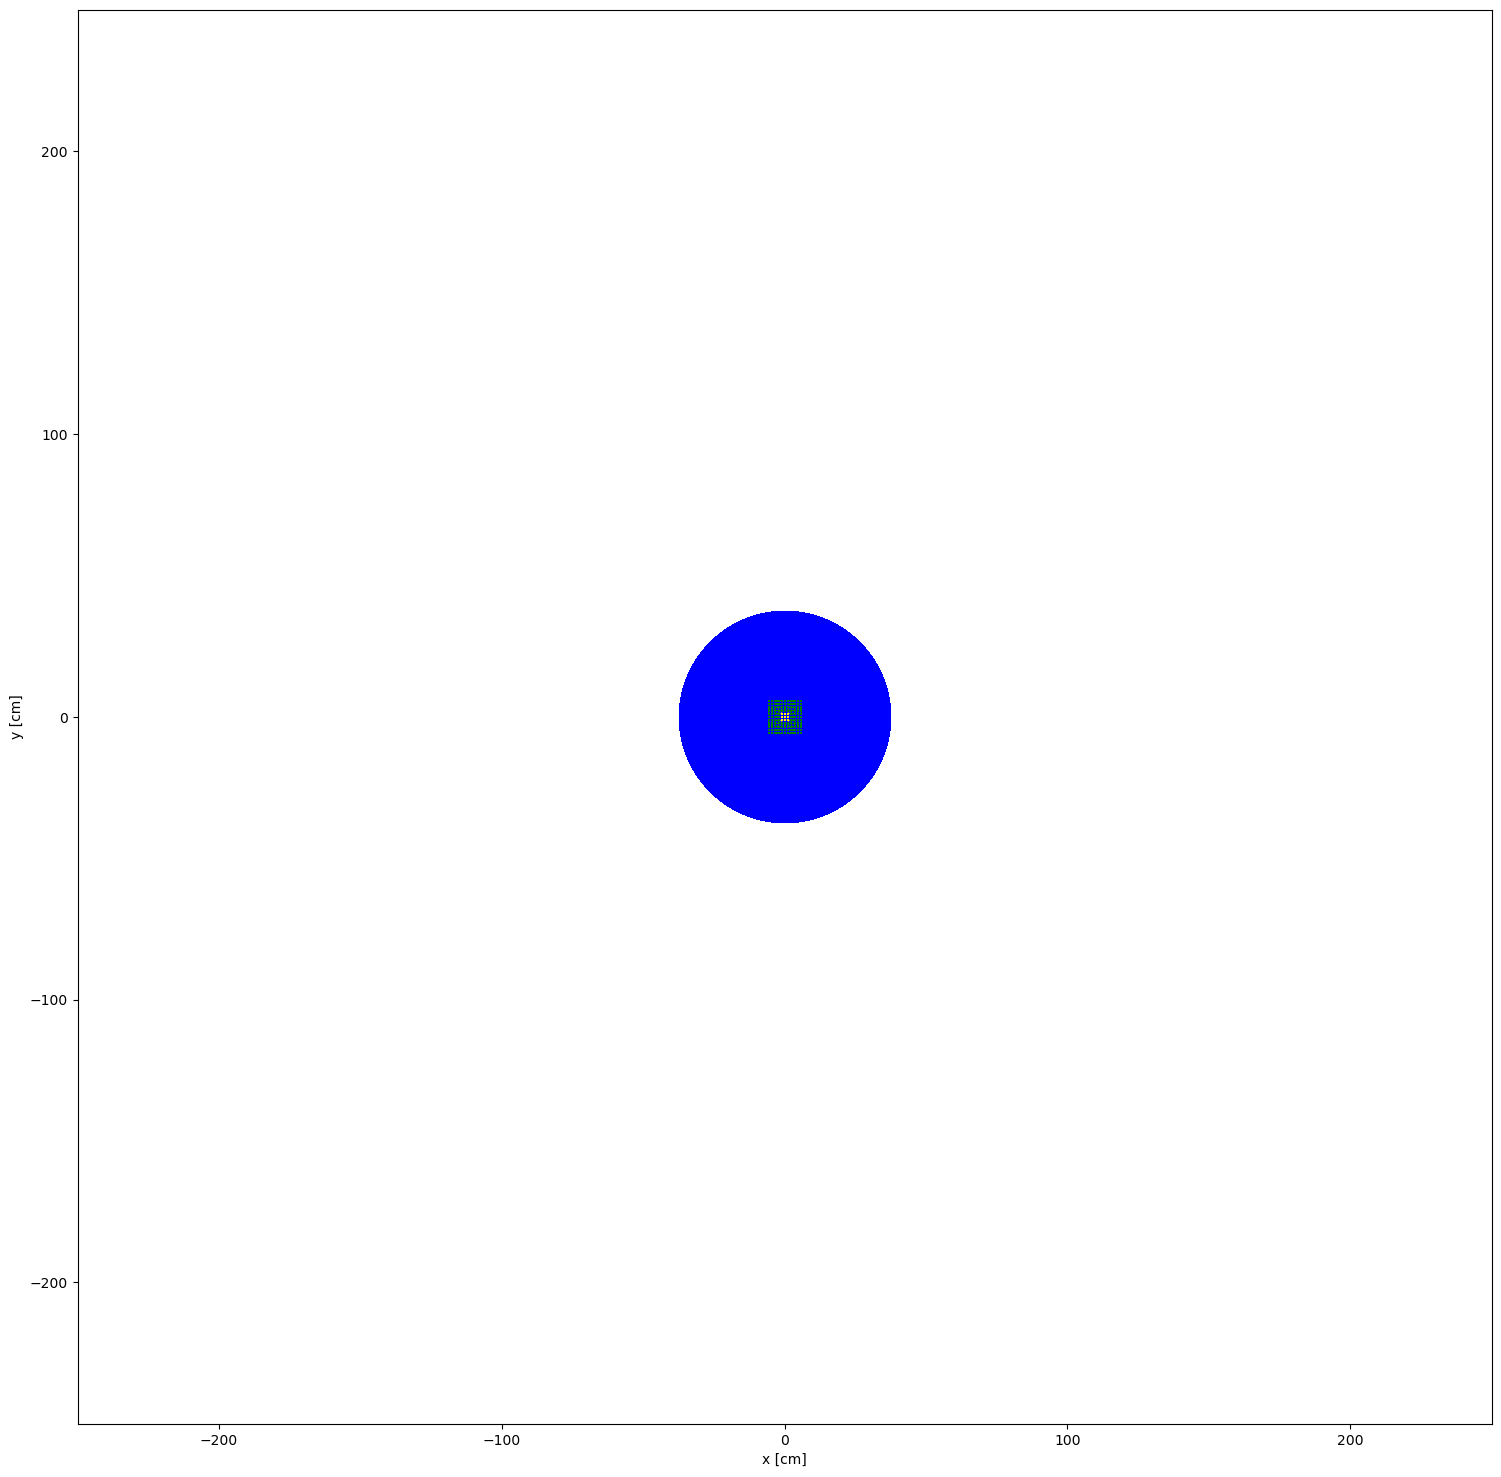

In [9]:
colors = {
    clad: 'grey',
    haleu: 'yellow',
    dep_u: 'green',
    sodium: 'blue'
}


plot_args = {
    'width':(500,500),
    'basis':'xy',
    'color_by':'material',
    'pixels': 2000000,
    'colors':colors
}

root.plot(**plot_args)

### Add settings for initial k_eff calculation

In [10]:
bounds = [-a_pitch/2, -a_pitch/2, -h_fuel/2, a_pitch/2, a_pitch/2, h_fuel/2];

uniform_dist = openmc.stats.Box(bounds[:3],bounds[3:],
                                only_fissionable=True);
settings = openmc.Settings()
settings.batches = 150;
settings.inactive = 50;
settings.particles = 10000;
settings.source = openmc.IndependentSource(space=uniform_dist);
settings.export_to_xml()



### Add some tallies

In [11]:
openmc.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

In [12]:
model = openmc.model.Model(geometry,materials,settings)
operator = openmc.deplete.CoupledOperator(model,"chain_endfb71_sfr.xml",
                                          diff_burnable_mats=True) 
power_density = 35 # MW/kg
days = 3600*24
time_steps = [0.1*days,0.2*days,0.3*days,0.5*days,1*days,10*days,10*days,30*days,30*days]
cemc = openmc.deplete.CECMIntegrator(operator,time_steps,power_density=power_density,
                                     timestep_units='s')
              


OSError: Error reading file 'chain_endfb_71_sfr.xml': failed to load external entity "chain_endfb_71_sfr.xml"